<a href="https://colab.research.google.com/github/MuhtasimMahadi/Muhtasim_Hossain/blob/main/Copy_of_EfficientNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Dataset from Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Libraries

In [2]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=95916345222d89697b0609da9855625305872f1e546f09a1f9e1ed3de1112937
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


# LIBRARIES

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Data Preprocessing

In [4]:
labels = ['Common_rust','gray_leaf_spot','healthy']

In [5]:
X_full = []
y_full = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/titl_defence/Dataset/final_crop_image',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 3450/3450 [03:09<00:00, 18.24it/s]


# Dividing the dataset as a Train & Test

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.2,random_state=101)

# Performing One Hot Encoding on the labels after converting it into numerical values

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# efficientNet

In [8]:
efficientNet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
efficientNet.trainable = False

In [14]:
model = tf.keras.models.Sequential([
  efficientNet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='softmax'),
])

# Compiling the Model

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              64226304  
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                      

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',verbose=1)

# Training the Model

In [17]:
hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1,
                 #epochs =15
                 epochs =30,
                 verbose=1,
                 batch_size=32,
                 #batch_size=16,
                  callbacks=[tensorboard,checkpoint,reduce_lr]
                 )

Epoch 1/30
240/240 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9251
Epoch 1: val_accuracy improved from -inf to 0.99296, saving model to CovidModelEfficientNet.h5
240/240 [==============================] - 52s 164ms/step - loss: 0.3479 - accuracy: 0.9251 - val_loss: 0.0251 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 2/30
240/240 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9774
Epoch 2: val_accuracy improved from 0.99296 to 0.99531, saving model to CovidModelEfficientNet.h5
240/240 [==============================] - 29s 123ms/step - loss: 0.0692 - accuracy: 0.9774 - val_loss: 0.0143 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 3/30
240/240 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9850
Epoch 3: val_accuracy improved from 0.99531 to 0.99883, saving model to CovidModelEfficientNet.h5
240/240 [==============================] - 26s 110ms/step - loss: 0.0569 - accuracy: 0.9850 - val_loss: 0.0071 - val_accuracy: 

# Accuracy of the Model

In [18]:
results = model.evaluate(X_train,y_train)

267/267 [==============================] - 17s 63ms/step - loss: 9.9775e-05 - accuracy: 1.0000


In [19]:
results2 = model.evaluate(X_test,y_test)

67/67 [==============================] - 6s 87ms/step - loss: 3.9781e-04 - accuracy: 1.0000


# Visualize of the Graph

In [20]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


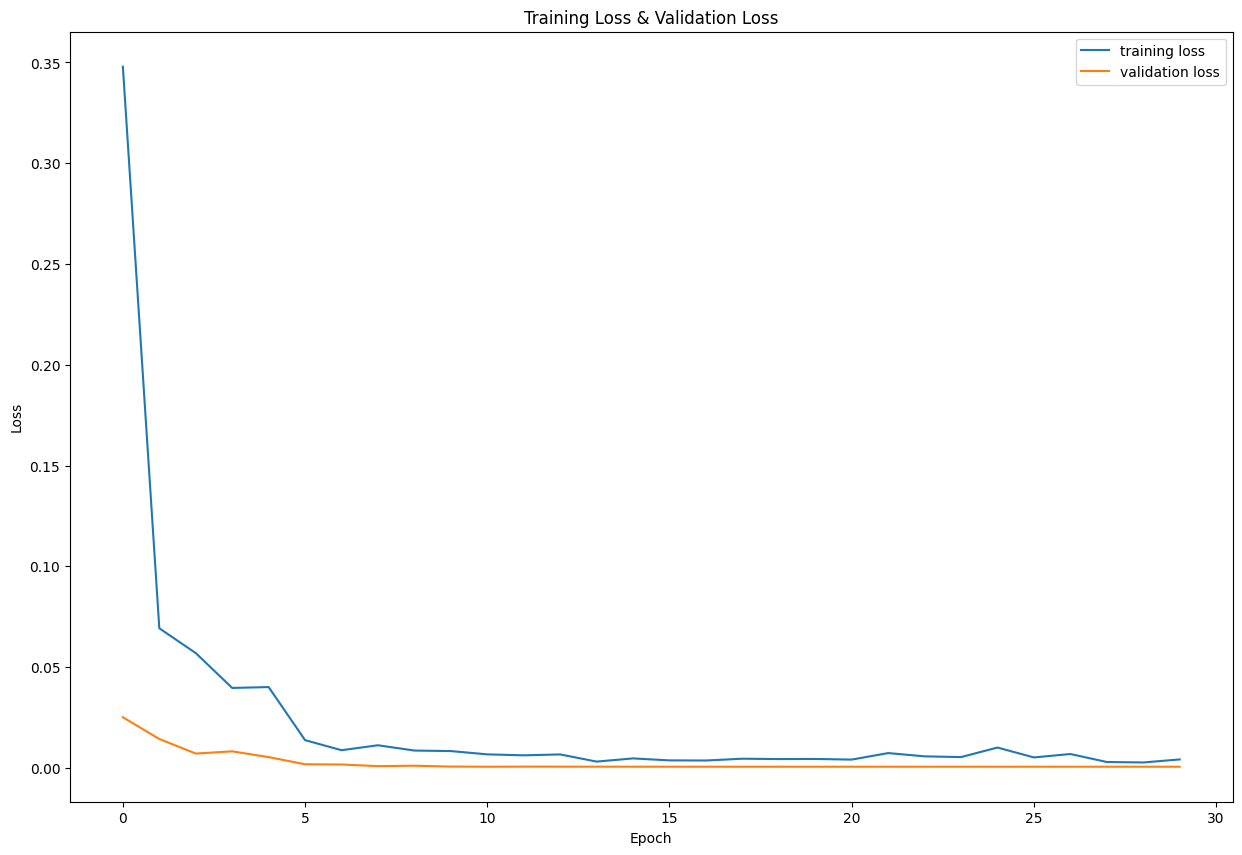

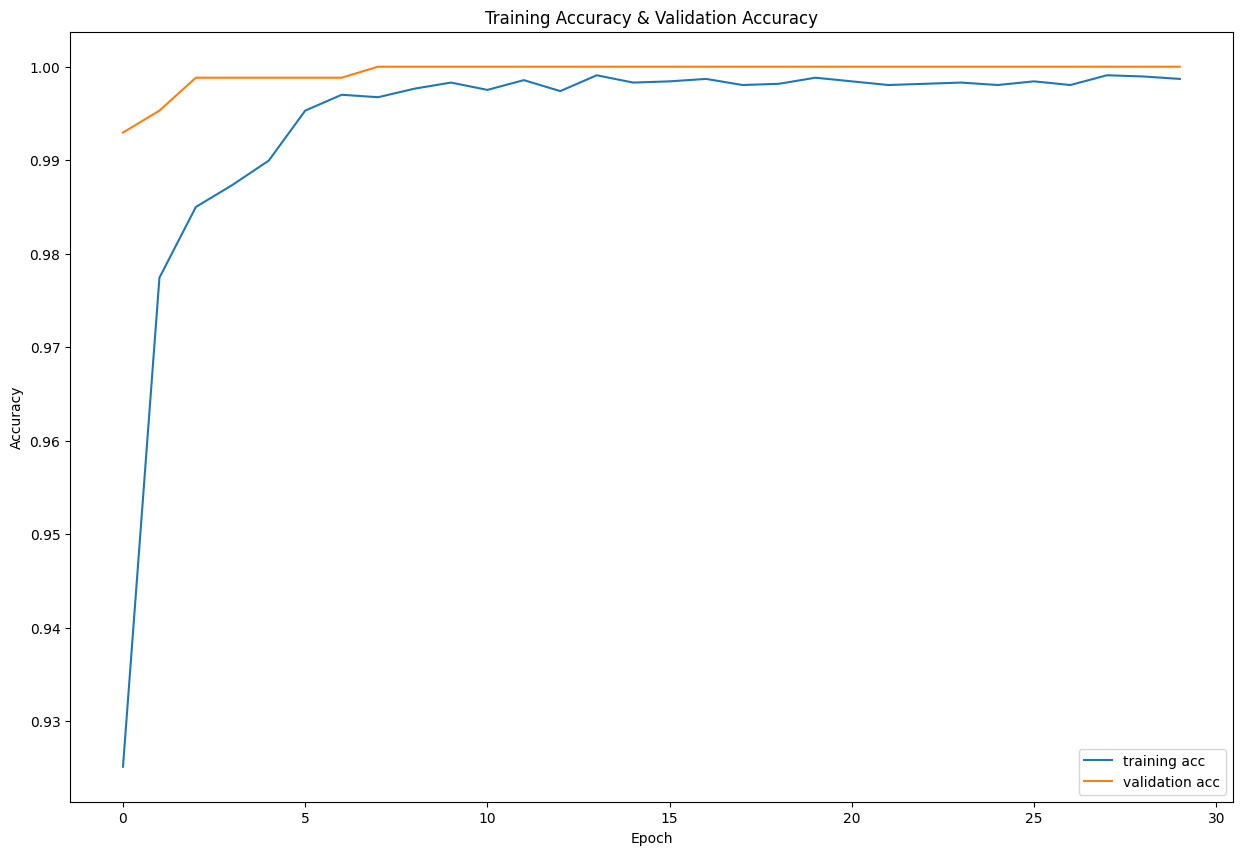

In [21]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# CLASSIFICATION REPORT

In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

67/67 [==============================] - 5s 58ms/step


In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       665
           2       1.00      1.00      1.00       733

    accuracy                           1.00      2130
   macro avg       1.00      1.00      1.00      2130
weighted avg       1.00      1.00      1.00      2130



# CONFUSION MATRIX

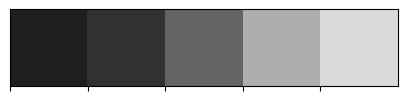

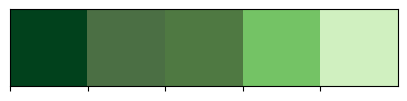

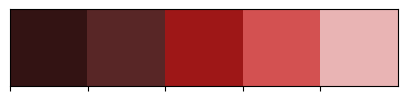

In [24]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

[[732   0   0]
 [  0 665   0]
 [  0   0 733]]


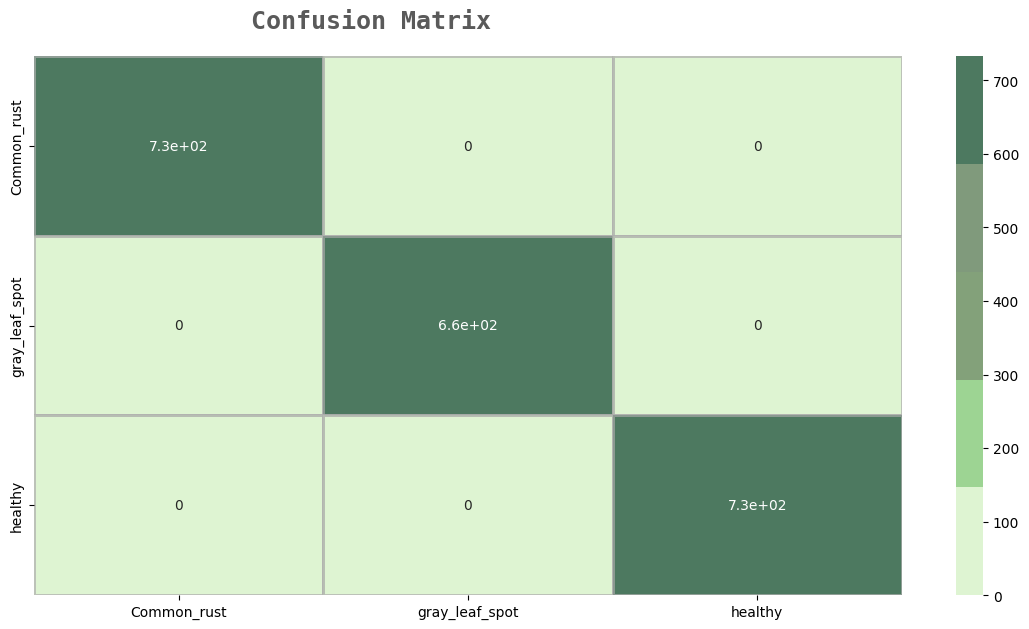

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3]
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()